<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/ode_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/yeoun9/torchpm.git
import torchpm as tcpm
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [11]:
dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO_ODE.csv'
column_names = ['ID', 'TIME', 'AMT', 'RATE', 'DV', 'MDV', 'CMT', 'COV']

device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
dataset = tcpm.data.CSVDataset(dataset_file_path, column_names, device)

class PKParameter(tcpm.funcgen.PKParameterGenerator) :
    def __call__(self, theta, eta) :
        k_a = theta[0]*tc.exp(eta[0])
        v = theta[1]*tc.exp(eta[1])
        k_e = theta[2]*tc.exp(eta[2])
        return {'k_a': k_a, 'v' : v, 'k_e': k_e}
pk_parameter = PKParameter()

class PredFunction(tcpm.funcgen.PredFunctionGenerator) :
    def __call__(self, t, y, theta, eta, cmt, amt, rate, pk, COV) :
        mat = tc.zeros(2,2, device=y.device)
        mat[0,0] = -pk['k_a']
        mat[1,0] = pk['k_a']
        mat[1,1] = -pk['k_e']
        return mat @ y
pred_fn = PredFunction()

class ErrorFunction(tcpm.funcgen.ErrorFunctionGenerator):
    def __call__(self, y_pred, eps, theta, eta, cmt, pk, COV) :
        v = pk['v']
        return y_pred/v + y_pred/v * eps[0] + eps[1]

error_fn = ErrorFunction()

theta_size = 3
theta_init = tc.tensor([ 1.5, 30,  0.1], device=device)
theta_lower_boundary  = tc.tensor([0.,0.,0.], device = device)
theta_upper_boundary  = tc.tensor([10,100,10], device = device)
theta_scale = tcpm.scale.ScaledVector(theta_init, lower_boundary = theta_lower_boundary, upper_boundary = theta_upper_boundary)
theta_init = tc.tensor([ 0.1, 0.1,  0.1], device=device)

eta_size = 3
omega_init = [tc.tensor([0.2,
                        0.1, 0.2,
                        0.1, 0.1, 0.2], device = device)]
omega_diagonals = [False]
omega_scales = [tcpm.scale.ScaledMatrix(omega_init[0], omega_diagonals[0])]
omega_inits = [tc.tensor([ 0.1,
                        0.1,  0.1,
                        0.1,  0.1,  0.1], device = device)]

eps_size = 2
sigma_init = [tc.tensor([0.2, 0.1], device = device)]
sigma_diagonals = [True]
sigma_scales = [tcpm.scale.ScaledMatrix(sigma_init[0], sigma_diagonals[0])]
sigma_inits = [tc.tensor([0.1, 0.1], device = device)]

pred_function_module = tcpm.predfunction.PredictionFunctionByODE(dataset = dataset,
                                                column_names = column_names,
                                                theta_size = theta_size,
                                                eta_size = eta_size,
                                                eps_size = eps_size,
                                                pk_parameter = pk_parameter,
                                                pred_fn  = pred_fn,
                                                error_fn = error_fn,
                                                theta_scale = theta_scale)

differential_module = tcpm.diff.DifferentialModule(omega_diagonals = omega_diagonals,
                                         sigma_diagonals = sigma_diagonals,
                                         omega_scales = omega_scales,
                                         sigma_scales = sigma_scales)

model = tcpm.model.FOCEInter(pred_function_module, differential_module)

model.pred_function_module.theta = tc.nn.Parameter(theta_init)
model.differential_module.sigma = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in sigma_inits])
model.differential_module.omega = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in omega_inits])
model = model.to(device)

#Model Fitting

In [12]:
model.fit_population(learning_rate = 1, tolerance_grad = 1e-3, tolerance_change= 1e-3)

running_time :  11.507620573043823 	 total_loss: tensor(312.4045, grad_fn=<AddBackward0>)
running_time :  22.35288166999817 	 total_loss: tensor(307.4793, grad_fn=<AddBackward0>)
running_time :  33.322304010391235 	 total_loss: tensor(281.8376, grad_fn=<AddBackward0>)
running_time :  43.707568407058716 	 total_loss: tensor(313.0083, grad_fn=<AddBackward0>)
running_time :  54.81269717216492 	 total_loss: tensor(244.7100, grad_fn=<AddBackward0>)
running_time :  65.62266659736633 	 total_loss: tensor(229.3756, grad_fn=<AddBackward0>)
running_time :  76.704106092453 	 total_loss: tensor(208.4243, grad_fn=<AddBackward0>)
running_time :  86.97079086303711 	 total_loss: tensor(197.0028, grad_fn=<AddBackward0>)
running_time :  97.69072341918945 	 total_loss: tensor(185.4647, grad_fn=<AddBackward0>)
running_time :  108.68743848800659 	 total_loss: tensor(176.4352, grad_fn=<AddBackward0>)
running_time :  119.72324252128601 	 total_loss: tensor(162.5324, grad_fn=<AddBackward0>)
running_time :  13

# Result

time-pred


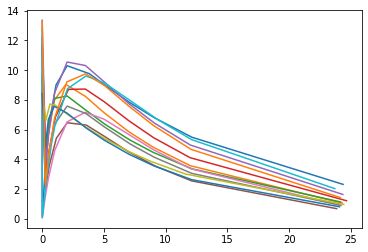

time-cwres


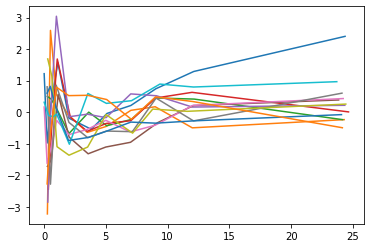

In [13]:
eval_result = model.evaluate()

print('time-pred')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    y_pred = eval_result['preds'][id]
    ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu').numpy())
plt.show()

print('time-cwres')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    cwres_value = eval_result['cwress'][id]
    ax.plot(time_data.masked_select(eval_result['mdv_masks'][id]).to('cpu'), cwres_value.detach().to('cpu').numpy())
plt.show()

In [14]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(126.4272)
losses
{'1': 15.985116004943848, '2': 23.14496612548828, '3': 2.212953567504883, '4': 13.372114181518555, '5': 27.35031509399414, '6': 7.635318756103516, '7': 2.6233444213867188, '8': 7.604714393615723, '9': 7.807849884033203, '10': 5.718816757202148, '11': 2.0572471618652344, '12': 10.914419174194336}
times
{'1': tensor([0.0000e+00, 1.0000e-02, 2.5000e-01, 5.7000e-01, 1.1200e+00, 2.0200e+00,
        3.8200e+00, 5.1000e+00, 7.0300e+00, 9.0500e+00, 1.2120e+01, 2.4370e+01]), '2': tensor([ 0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,  7.0300,
         9.0000, 12.0000, 24.3000]), '3': tensor([ 0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,  7.0700,
         9.0000, 12.1500, 24.1700]), '4': tensor([ 0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,  7.0200,
         9.0200, 11.9800, 24.6500]), '5': tensor([ 0.0000,  0.3000,  0.5200,  1.0000,  2.0200,  3.5000,  5.0200,  7.0200,
         9.1000, 12.0000, 24.3500]), '6': t

In [15]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 1.5197e-03,  1.1946e-02, -1.1216e-04,  1.8633e-03,  2.8787e-04,
         -6.3620e-05,  2.6034e-05,  8.5598e-05,  1.8247e-04, -2.5184e-04,
          7.4805e-04],
        [ 2.2227e-02,  2.6938e-01, -2.1705e-03,  2.0285e-02,  1.0452e-04,
         -1.2342e-03, -5.2796e-05,  2.0080e-03,  2.5682e-03, -2.9565e-03,
         -7.4189e-03],
        [-1.1568e-04, -1.4983e-03,  1.1580e-05, -5.9897e-05,  3.7460e-06,
          5.5608e-06, -4.1582e-06, -1.1328e-05, -1.5940e-05,  1.2398e-05,
          2.7730e-05],
        [ 4.0688e-04,  3.8308e-04, -6.9810e-05,  2.7881e-02,  4.7210e-03,
          4.6732e-04, -8.0597e-04, -2.4765e-04, -4.5927e-04, -2.5306e-05,
         -7.4016e-03],
        [ 4.7037e-06, -3.2386e-03,  3.6138e-06,  4.7253e-03,  1.0446e-03,
          1.2734e-04,  3.2066e-05, -5.6898e-05, -1.0125e-04, -7.8789e-06,
         -9.3401e-04],
        [-4.3472e-05, -6.4173e-04,  2.8080e-06,  4.6931e-04,  1.2705e-04,


In [16]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().numpy())

pred_function_module.theta
[ 1.3396821  30.156416    0.09387702]
pred_function_module.cur_eta
[-0.5569212  -0.22356674  0.04166774]
pred_function_module.etas.1
[-0.00546974 -0.13938361 -0.2885947 ]
pred_function_module.etas.2
[ 0.11286892 -0.03272257  0.05410399]
pred_function_module.etas.3
[ 0.4885549   0.09487406 -0.03900464]
pred_function_module.etas.4
[-0.387506   -0.09015837  0.02185741]
pred_function_module.etas.5
[-0.20325693 -0.22972463 -0.04683775]
pred_function_module.etas.6
[-0.33760172  0.19375335  0.17612123]
pred_function_module.etas.7
[-0.7619133   0.02460336  0.14966382]
pred_function_module.etas.8
[-0.06244545  0.11608148  0.06244055]
pred_function_module.etas.9
[ 1.435737    0.24645466 -0.05843173]
pred_function_module.etas.10
[-0.66327614 -0.19021308 -0.12090586]
pred_function_module.etas.11
[0.93758243 0.23110087 0.04572042]
pred_function_module.epss.1
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
pred_f

#Simulation

id 1


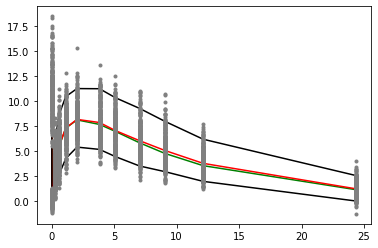

id 2


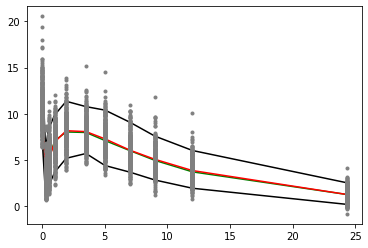

id 3


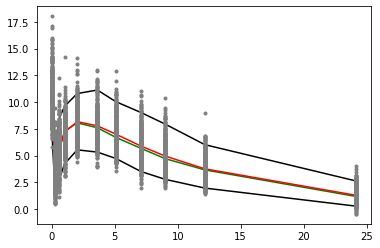

id 4


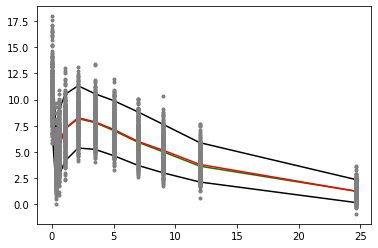

id 5


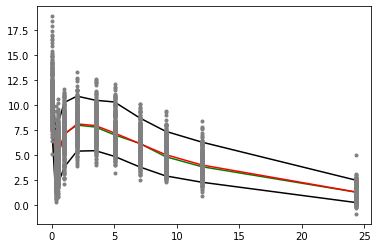

id 6


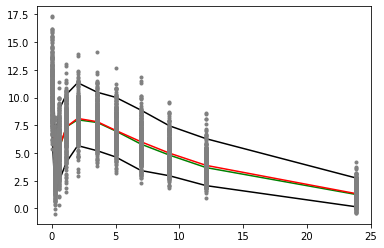

id 7


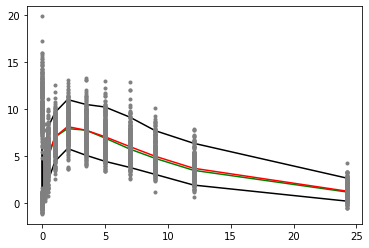

id 8


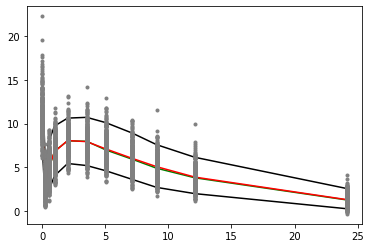

id 9


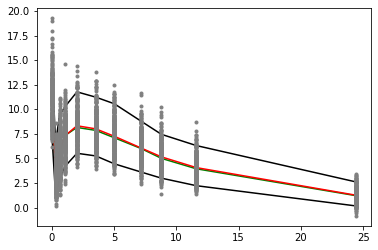

id 10


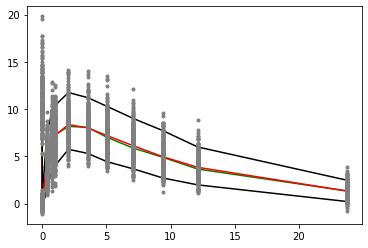

id 11


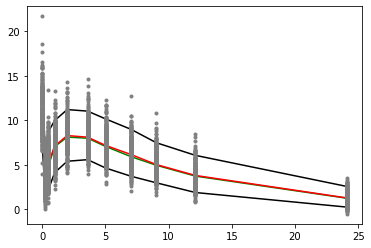

id 12


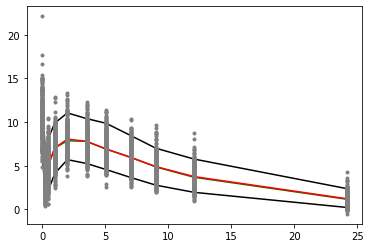

In [17]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, time_data in simulation_result['times'].items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    
    p95 = np.percentile(tc.stack(simulation_result['preds'][id]), 95, 0)
    p50 = np.percentile(tc.stack(simulation_result['preds'][id]), 50, 0)
    average = np.average(tc.stack(simulation_result['preds'][id]), 0)
    p5 = np.percentile(tc.stack(simulation_result['preds'][id]), 5, 0)
    
    ax.plot(time_data.to('cpu'), p95, color="black")
    ax.plot(time_data.to('cpu'), p50, color="green")
    ax.plot(time_data.to('cpu'), average, color="red")
    ax.plot(time_data.to('cpu'), p5, color="black")
    
    for y_pred in simulation_result['preds'][id] :
        ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()